# Modeling

In [1]:
# importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_model = pd.read_csv('./Data/clean_data.csv', index_col=0)
df_model.head()

,amount_tsh,date_recorded,funder,gps_height,basin,region,local_government_area,population,permit,construction_year,extraction_type_class,management_group,payment_type,water_quality,quantity,source_type,waterpoint_type,status_group,construction_decade
0,6000.0,2011-03-14,Roman,1390,Lake Nyasa,Iringa,Ludewa,109,False,1999,gravity,user-group,annually,soft,enough,spring,communal standpipe,functional,1990s (1990-1999)
1,0.0,2013-03-06,Grumeti,1399,Lake Victoria,Mara,Serengeti,280,True,2010,gravity,user-group,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional,2000s (2000-2009)
2,25.0,2013-02-25,Lottery Club,686,Pangani,Manyara,Simanjiro,250,True,2009,gravity,user-group,per bucket,soft,enough,dam,communal standpipe multiple,functional,2000s (2000-2009)
3,0.0,2013-01-28,Unicef,263,Ruvuma / Southern Coast,Mtwara,Nanyumbu,58,True,1986,submersible,user-group,never pay,soft,dry,borehole,communal standpipe multiple,non functional,1980s (1980-1989)
4,0.0,2011-07-13,Action In A,0,Lake Victoria,Kagera,Karagwe,0,True,0,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional,Unknown


In [3]:
categorical_cols = ['region', 'extraction_type_class', 'management_group', 'funder',
                    'quantity', 'water_quality' , 'waterpoint_type', 'source_type', 'status_group' ]

In [4]:
numerical_cols = ['amount_tsh','gps_height', 'population']

In [5]:
df_model.drop(['date_recorded', 'construction_year', 'basin', 'local_government_area', 
                     'payment_type', 'permit', 'construction_decade'], axis=1, inplace=True)
#to be dropped before one hot encoding

In [6]:
# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Encode the categorical columns in the DataFrame
for col in categorical_cols:
    df_model[col] = encoder.fit_transform(df_model[col])

# covert categorical columns to integer
for col in categorical_cols:
    df_model[col] = df_model[col].astype(int)

In [ ]:
#from category_encoders import OneHotEncoder
#ohe = OneHotEncoder(cols = categorical_cols)

In [ ]:
#df_model = ohe.fit_transform(df_model)

In [7]:
df_model.head()

,amount_tsh,funder,gps_height,region,population,extraction_type_class,management_group,water_quality,quantity,source_type,waterpoint_type,status_group
0,6000.0,1319,1390,3,109,0,4,6,1,6,1,0
1,0.0,457,1399,9,280,0,4,6,2,3,1,0
2,25.0,803,686,8,250,0,4,6,1,1,2,0
3,0.0,1681,263,12,58,5,4,6,0,0,2,1
4,0.0,18,0,4,0,0,1,6,3,3,1,0


In [8]:
# split the dataset
X = df_model.drop('status_group', axis=1)
y = df_model['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56344 entries, 0 to 59399
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             56344 non-null  float64
 1   funder                 56344 non-null  int32  
 2   gps_height             56344 non-null  int64  
 3   region                 56344 non-null  int32  
 4   population             56344 non-null  int64  
 5   extraction_type_class  56344 non-null  int32  
 6   management_group       56344 non-null  int32  
 7   water_quality          56344 non-null  int32  
 8   quantity               56344 non-null  int32  
 9   source_type            56344 non-null  int32  
 10  waterpoint_type        56344 non-null  int32  
dtypes: float64(1), int32(8), int64(2)
memory usage: 3.4 MB


## Models

My data is now ready to be modeled. To begin, we will fit a dummy cllassifier model as my baseline model and analyze its performance indicators. Following that, I will fit several more classification models and evaluate their performance measures.

I will choose the two best-performing models from the four models based on accuracy. The remaining two models will subsequently be tuned with ensemble methods.


### 1. Dummy Classifier - Baseline model

> DummyClassifier makes predictions that ignore the input features. This classifier serves as a simple baseline to compare against other more complex classifiers.

- In terms of accuracy, the dummy classifier achieves an accuracy of 0.53, meaning that it correctly predicts the class for around 53% of the instances.

- Overall, these results indicate that the dummy classifier performs poorly in predicting class 1, as it never correctly identifies any instances of that class. It performs better in predicting class 0, achieving a reasonable precision and recall.

In [10]:
#Build a pipeline with a StandardScaler and a DummyClassifier
dummy_pipe = Pipeline([('scaler', StandardScaler()), 
                ('dummy', DummyClassifier(random_state=42))])
# fit the pipeline to the training set
dummy_pipe.fit(X_train, y_train)
# make predictions on the test set
y_pred_dummy = dummy_pipe.predict(X_test)
# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_dummy))

Classification Report:
              precision    recall  f1-score   support

           0       0.53      1.00      0.70      7534
           1       0.00      0.00      0.00      6552

    accuracy                           0.53     14086
   macro avg       0.27      0.50      0.35     14086
weighted avg       0.29      0.53      0.37     14086



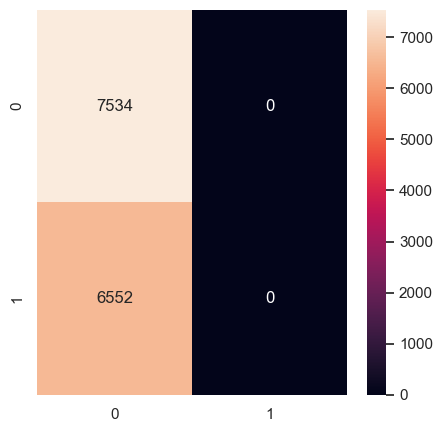

In [13]:
# Plot the confusion matrix without a color palette
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_dummy), annot=True, fmt='g')

# Show the plot
plt.show()

#Logistic regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Create a pipeline with a StandardScaler and a LogisticRegression classifier
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('logreg', LogisticRegression(random_state=42))
])

# Fit the pipeline to the training set
logreg_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_logreg = logreg_pipeline.predict(X_test)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_logreg))


Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.67      0.63      7534
           1       0.57      0.50      0.53      6552

    accuracy                           0.59     14086
   macro avg       0.59      0.58      0.58     14086
weighted avg       0.59      0.59      0.59     14086



Thats really low for a second classifier. Logistic regression is suppossed to do the below;  

Logistic regression is a statistical model commonly used for binary classification tasks, where the goal is to predict one of two possible classes (e.g., 0 or 1, "yes" or "no").  

Logistic regression outputs probability scores for each class.   

 probabilities represent the likelihood that a given input belongs to a particular class. For a binary classification problem, logistic regression calculates the probability that an observation belongs to the positive class (typically labeled as 1).

In [17]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Load your data into a DataFrame
df = pd.read_csv('./Data/clean_data.csv')  # Replace 'your_file.csv' with the actual file path

# Split your data into features and target variable
X = df.drop('status_group', axis=1)  # Replace 'status_group' with the name of your target variable
y = df['status_group']  # Target variable

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining the preprocessing for numerical and categorical columns
numerical_cols = ['amount_tsh', 'gps_height', 'population']
categorical_cols = ['region', 'extraction_type_class', 'management_group', 'funder',
                    'quantity', 'water_quality', 'waterpoint_type', 'source_type']

# Define preprocessing for numerical data (imputation + scaling)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical data (imputation + one-hot encoding)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create the logistic regression pipeline
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Fit the pipeline to the training data
logreg_pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logreg_pipeline.predict(X_test)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                precision    recall  f1-score   support

    functional       0.73      0.85      0.78      6039
non functional       0.79      0.63      0.70      5230

      accuracy                           0.75     11269
     macro avg       0.76      0.74      0.74     11269
  weighted avg       0.75      0.75      0.74     11269



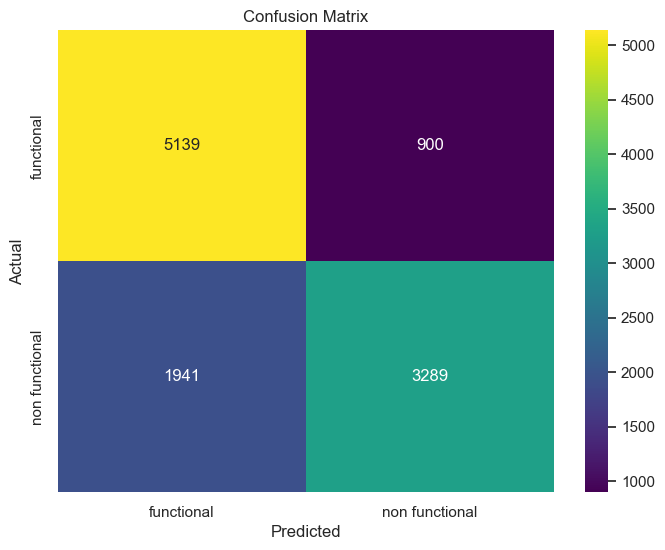

In [21]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with a colored heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=logreg_pipeline.classes_, yticklabels=logreg_pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### 2. Decision Tree Classifier

> Decision Tree is a Supervised learning technique that can be used for both classification and Regression problems, but mostly it is preferred for solving Classification problems. The intuition behind Decision Trees is that you use the dataset features to create yes/no questions and continually split the dataset until you isolate all data points belonging to each class.

In [ ]:
# Create a pipeline with a decision tree classifier as the estimator:
dt = Pipeline([('scaler', StandardScaler()),
                  ('tree', DecisionTreeClassifier(random_state=42))])
# fit the pipeline to the training set
dt.fit(X_train, y_train)
# make predictions on the test set
y_pred_dt = dt.predict(X_test)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))


In [ ]:
# Plot the confusion matrix without a color palette
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='g')

# Show the plot
plt.show()

- The accuracy score represents the proportion of correctly predicted instances out of the total number of instances. In this case, the decision tree model achieved an accuracy of around 0.75, indicating that it predicted 75% of instances correctly.

### 3. Random Forest Classifier

> A Random Forest Classifier is a popular machine learning algorithm used for classification tasks. It belongs to the family of ensemble methods, which combine multiple individual models to make predictions. The Random Forest algorithm constructs a multitude of decision trees during training and outputs the class that is the mode of the classes predicted by the individual trees.

In [ ]:
# Create a pipeline with a StandardScaler and a RandomForestClassifier.
rf = Pipeline([('scaler', StandardScaler()),
                  ('rf', RandomForestClassifier(random_state=42))])
# fit the pipeline to the training data
rf.fit(X_train, y_train);
# make predictions on the test data
y_pred_rf = rf.predict(X_test)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))


In [ ]:
# plot the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='g', cmap=color_palette);

- The overall accuracy of the model is 0.78, indicating that it correctly predicts approximately 78% of the instances.

### 4. Support Vector Machine (SVM) classifier

> A Support Vector Machine (SVM) classifier is a powerful supervised machine learning algorithm used for both classification and regression tasks. It is particularly effective in handling high-dimensional feature spaces and datasets with clear separation between classes

In [ ]:
svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=42))
])

# Fit the pipeline on the training data
svm_clf.fit(X_train, y_train)

# Make predictions on the test data using the trained pipeline
y_pred_svm = svm_clf.predict(X_test)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

In [ ]:
# plot the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='g', cmap=color_palette);

- The overall accuracy of the model is 0.73, indicating that it correctly predicts approximately 73% of the instances.

###  5. K-Nearest Neighbors

> K-Nearest Neighbors (KNN) is a simple yet effective machine learning algorithm used for both classification and regression tasks. It is a non-parametric algorithm that makes predictions based on the similarity of data points in the feature space.

In [ ]:
knn_clf = Pipeline([('scaler', StandardScaler()),
                     ('knn_clf', KNeighborsClassifier())
])

# Fit the pipeline to the training data
knn_clf.fit(X_train, y_train)

# make predictions on test data
y_pred_knn = knn_clf.predict(X_test)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))

- The accuracy of the model is 0.76, indicating that it correctly classifies 76% of the instances.

### 6. K-Nearest Neighbors with grid search

In [ ]:
# Define the parameter grid for GridSearchCV
param_grid_knn = {
    'knn_clf__n_neighbors': [3, 5, 7],
    'knn_clf__weights': ['uniform', 'distance'],
    'knn_clf__p': [1, 2]
}

# Create the GridSearchCV object
gridsearch_knn = GridSearchCV(estimator=knn_clf, param_grid=param_grid_knn, cv=5, verbose=2, n_jobs=-1)

# Fit the GridSearchCV on the training data
gridsearch_knn.fit(X_train, y_train)

# Get the best parameters
best_params_knn = gridsearch_knn.best_params_

print("Best Parameters:", best_params_knn)

# Make predictions on the test data using the trained pipeline
y_pred_gridsearchknn = gridsearch_knn.predict(X_test)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_gridsearchknn))

Best Parameters: The best parameters found during the grid search are:

- Number of neighbors (knn_clf__n_neighbors): 7
- Distance metric power parameter (knn_clf__p): 1
- Weighting scheme (knn_clf__weights): 'distance'


- Accuracy: The accuracy of the model is 0.77, indicating that it correctly classifies 77% of the instances.

### 7. Decision Tree with GridsearchCV

In [ ]:
dt = Pipeline([('scaler', StandardScaler()),
                  ('tree', DecisionTreeClassifier(random_state=42))])
# create a grid of parameters to test

param_grid = [{'tree__max_depth': [16, 18, 20],
              'tree__min_samples_split': [4, 6, 8],
              'tree__min_samples_leaf': [2, 3, 4],
              'tree__criterion': ['gini', 'entropy']}]

# create grid with estimators
gridsearch_dt = GridSearchCV(dt, param_grid, cv=5, n_jobs=-1, verbose=1)

# fit the grid with the data    
gridsearch_dt.fit(X_train, y_train);

# Get the best parameters
best_params_dt = gridsearch_dt.best_params_

print("Best Parameters:", best_params_dt)
# Make predictions on the test data using the trained pipeline
y_pred_gridsearchdt = gridsearch_dt.predict(X_test)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_gridsearchdt))

In [ ]:
# plot the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred_gridsearchdt), annot=True, fmt='g', cmap=color_palette);

### 8. Random Forest with GridsearchCV

In [25]:
# Define the parameter grid for GridSearchCV
param_grid_rf = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [7, 8],
    'rf__max_features': [7, 8],
    'rf__min_samples_leaf': [1, 2],
    'rf__min_samples_split': [2, 3],
    'rf__criterion': ['gini', 'entropy'],
    'rf__bootstrap': [True, False],
    'rf__random_state': [42]
}

# Create the GridSearchCV object
gridsearch_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, verbose=2, n_jobs=-1)

# Fit the GridSearchCV on the training data
gridsearch_rf.fit(X_train, y_train)

# Get the best parameters
best_params_rf = gridsearch_rf.best_params_

print("Best Parameters:", best_params_rf)

# Make predictions on the test data using the trained pipeline
y_pred_gridsearchrf = gridsearch_rf.predict(X_test)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_gridsearchrf))

In [ ]:
# plot the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred_gridsearchrf), annot=True, fmt='g', cmap=color_palette);

- Best Parameters: The best parameters found during the grid search are:

    - Bootstrap (rf__bootstrap): False
    - Splitting criterion (rf__criterion): 'gini'
    - Maximum depth of trees (rf__max_depth): 8
    - Maximum number of features considered for splitting (rf__max_features): 7
    - Minimum number of samples required to be at a leaf node (rf__min_samples_leaf): 2
    - Minimum number of samples required to split an internal node (rf__min_samples_split): 2
    - Number of trees in the random forest (rf__n_estimators): 300
    - Random state for reproducibility (rf__random_state): 42

 - The accuracy of the model is 0.74, indicating that it correctly classifies 74% of the instances.

The best performing model was the Random Forest Classifier with an accuracy of 78% and KNN with grid search with an accuracy of 77%

### Conclusion

The Lake Rukwa basin area, where there are considerably more non-functional wells than functional ones, may be worth considering for our stakeholders when they decide to build more wells in Tanzania. There are more non-functional wells than functioning ones in the Dodoma region; this situation has to be investigated. Over the course of time, wells with operating permission typically become more viable and useful than those without. Due to possible public misuse, unpaid wells frequently become inoperable; perhaps creating a reasonable payment plan will help stop this. Because wells without permissions also have a higher likelihood of becoming inoperable, our stakeholder must verify that they have permits to ensure that they are acceptable.